In [51]:
import numpy as np      
import matplotlib.pyplot as plt 
import scipy.io.wavfile 
import subprocess
import librosa
import librosa.display
import IPython.display as ipd

from pathlib import Path, PurePath   
from tqdm.notebook import tqdm
import random
import difflib

## Utility functions

In [2]:
def convert_mp3_to_wav(audio:str) -> str:  
    """Convert an input MP3 audio track into a WAV file.

    Args:
        audio (str): An input audio track.

    Returns:
        [str]: WAV filename.
    """
    if audio[-3:] == "mp3":
        wav_audio = audio[:-3] + "wav"
        if not Path(wav_audio).exists():
                subprocess.check_output(f"ffmpeg -i {audio} {wav_audio}", shell=True)
        return wav_audio
    
    return audio

def plot_spectrogram_and_peaks(track:np.ndarray, sr:int, peaks:np.ndarray, onset_env:np.ndarray) -> None:
    """Plots the spectrogram and peaks 

    Args:
        track (np.ndarray): A track.
        sr (int): Aampling rate.
        peaks (np.ndarray): Indices of peaks in the track.
        onset_env (np.ndarray): Vector containing the onset strength envelope.
    """
    times = librosa.frames_to_time(np.arange(len(onset_env)),
                            sr=sr, hop_length=HOP_SIZE)

    plt.figure()
    ax = plt.subplot(2, 1, 2)
    D = librosa.stft(track)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(D), ref=np.max),
                            y_axis='log', x_axis='time')
    plt.subplot(2, 1, 1, sharex=ax)
    plt.plot(times, onset_env, alpha=0.8, label='Onset strength')
    plt.vlines(times[peaks], 0,
            onset_env.max(), color='r', alpha=0.8,
            label='Selected peaks')
    plt.legend(frameon=True, framealpha=0.8)
    plt.axis('tight')
    plt.tight_layout()
    plt.show()
    
def load_audio_peaks(audio, offset, duration, hop_size):
    """Load the tracks and peaks of an audio.

    Args:
        audio (string, int, pathlib.Path or file-like object): [description]
        offset (float): start reading after this time (in seconds)
        duration (float): only load up to this much audio (in seconds)
        hop_size (int): the hop_length

    Returns:
        tuple: Returns the audio time series (track) and sampling rate (sr), a vector containing the onset strength envelope
        (onset_env), and the indices of peaks in track (peaks).
    """
    try:
        track, sr = librosa.load(audio, offset=offset, duration=duration)
        onset_env = librosa.onset.onset_strength(track, sr=sr, hop_length=hop_size)
        peaks = librosa.util.peak_pick(onset_env, 10, 10, 10, 10, 0.5, 0.5)
    except Error as e:
        print('An error occurred processing ', str(audio))
        print(e)

    return track, sr, onset_env, peaks

## Settings

In [3]:
N_TRACKS = 1413
HOP_SIZE = 512
OFFSET = 1.0
DURATION = 30 # TODO: to be tuned!
THRESHOLD = 0 # TODO: to be tuned!

In [4]:
data_folder = Path("mp3s-32k/")
mp3_tracks = data_folder.glob("*/*/*.mp3")
tracks = data_folder.glob("*/*/*.wav")

## Preprocessing

In [5]:
for track in tqdm(mp3_tracks, total=N_TRACKS):
    audio = convert_mp3_to_wav(str(track))

## Audio signals

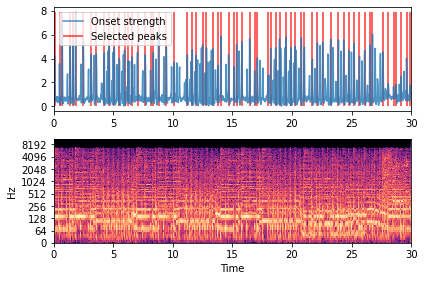

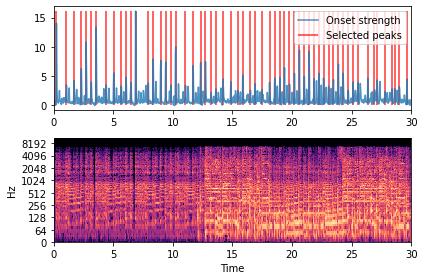

In [6]:
for idx, audio in enumerate(tracks):
    if idx >= 2:
        break
    track, sr, onset_env, peaks = load_audio_peaks(audio, OFFSET, DURATION, HOP_SIZE)
    plot_spectrogram_and_peaks(track, sr, peaks, onset_env)

## 1.2.1 Implement minhash from scratch

In [8]:
# we create a dictonary "track_song", in which, for every title song, we store the index of the peaks and the value of 
# the peaks
# we create a list called peak, in which we collect all the peak_value of the songs

track_song = dict()
peak_1 = list()
titles = dict()
for idx, audio in enumerate(tqdm(tracks)):
    track, sr, onset_env, peaks = load_audio_peaks(audio, OFFSET, DURATION, HOP_SIZE)
    #to make the title equal to all.list
    audio = str(audio).replace("mp3s-32k\\", "").replace("\\", "/").replace(".wav", "")
    titles[idx] = audio
    for i in peaks:
        if idx not in track_song:
            track_song[idx] = [onset_env[i]]
        else:
            track_song[idx].append(onset_env[i])
        peak_1.append(onset_env[i])

In [9]:
print(titles)

{0: 'aerosmith/Aerosmith/05-Mama_Kin', 1: 'aerosmith/Aerosmith/06-Write_Me_a_Letter', 2: 'aerosmith/Aerosmith/07-Movin_Out', 3: 'aerosmith/Aerosmith/08-Walking_the_Dog', 4: 'aerosmith/Draw_the_Line/01-Draw_the_Line', 5: 'aerosmith/Draw_the_Line/02-I_Wanna_Know_Why', 6: 'aerosmith/Draw_the_Line/03-Critical_Mass', 7: 'aerosmith/Draw_the_Line/04-Get_It_Up', 8: 'aerosmith/Draw_the_Line/05-Bright_Light_Fright', 9: 'aerosmith/Draw_the_Line/06-Kings_and_Queens', 10: 'aerosmith/Draw_the_Line/07-The_Hand_That_Feeds', 11: 'aerosmith/Draw_the_Line/08-Sight_for_Sore_Eyes', 12: 'aerosmith/Draw_the_Line/09-Milk_Cow_Blues', 13: 'aerosmith/Get_Your_Wings/01-Same_Old_Song_and_Dance', 14: 'aerosmith/Get_Your_Wings/02-Lord_Of_The_Thighs', 15: 'aerosmith/Get_Your_Wings/03-Spaced', 16: 'aerosmith/Get_Your_Wings/04-Woman_Of_The_World', 17: 'aerosmith/Get_Your_Wings/05-SOS', 18: 'aerosmith/Get_Your_Wings/06-Train_Kept_A_Rollin_', 19: 'aerosmith/Get_Your_Wings/07-Seasons_Of_Wither', 20: 'aerosmith/Get_Your_Wi

In [10]:
#this print to see what's inside the track_song dictonary
print(len(track_song))
print("tracks song dictonary is: ", track_song)

1409
tracks song dictonary is:  {0: [6.879326, 6.7969065, 4.458893, 8.04142, 2.9707286, 3.6628108, 2.5821152, 7.2035913, 8.17554, 9.753355, 6.6970716, 5.7038555, 1.6245073, 2.8595912, 5.964085, 2.2606463, 4.9281917, 3.663382, 2.4990406, 3.9332104, 5.602337, 3.2700117, 6.823093, 4.6778574, 3.102179, 4.6830106, 4.286585, 2.7867515, 2.8006914, 4.703781, 2.5013657, 3.455588, 3.566911, 3.1246793, 3.1220303, 3.668342, 3.269913, 2.9005597, 5.7332044, 3.54257, 3.469807, 4.686258, 3.2096798, 3.4476597, 3.2394621, 2.9886048, 4.2771764, 3.139048, 4.0385747, 3.653501, 3.2226057, 2.8497944, 4.216238, 4.212892, 3.98524, 4.3016505, 4.1720815, 3.5844617, 4.4801803, 3.4385464, 2.371858], 1: [12.551444, 11.053045, 4.7123895, 6.8022885, 4.5752773, 9.027273, 5.3828425, 6.040831, 7.1759686, 10.825645, 12.213888, 7.3553543, 9.152208, 9.91563, 8.697317, 5.218636, 5.851309, 8.206196, 5.8048115, 7.210756, 6.8560705, 6.8605366, 8.410729, 5.4772663, 5.0029054, 5.982088, 3.8264582, 5.126455, 6.8527803, 4.040626, 

In [11]:
#this print to see what's inside peak
print(len(peak_1))
print("all the peaks we have are: ", peak_1)

93382
all the peaks we have are:  [6.879326, 6.7969065, 4.458893, 8.04142, 2.9707286, 3.6628108, 2.5821152, 7.2035913, 8.17554, 9.753355, 6.6970716, 5.7038555, 1.6245073, 2.8595912, 5.964085, 2.2606463, 4.9281917, 3.663382, 2.4990406, 3.9332104, 5.602337, 3.2700117, 6.823093, 4.6778574, 3.102179, 4.6830106, 4.286585, 2.7867515, 2.8006914, 4.703781, 2.5013657, 3.455588, 3.566911, 3.1246793, 3.1220303, 3.668342, 3.269913, 2.9005597, 5.7332044, 3.54257, 3.469807, 4.686258, 3.2096798, 3.4476597, 3.2394621, 2.9886048, 4.2771764, 3.139048, 4.0385747, 3.653501, 3.2226057, 2.8497944, 4.216238, 4.212892, 3.98524, 4.3016505, 4.1720815, 3.5844617, 4.4801803, 3.4385464, 2.371858, 12.551444, 11.053045, 4.7123895, 6.8022885, 4.5752773, 9.027273, 5.3828425, 6.040831, 7.1759686, 10.825645, 12.213888, 7.3553543, 9.152208, 9.91563, 8.697317, 5.218636, 5.851309, 8.206196, 5.8048115, 7.210756, 6.8560705, 6.8605366, 8.410729, 5.4772663, 5.0029054, 5.982088, 3.8264582, 5.126455, 6.8527803, 4.040626, 5.31175

### Shingling

In [12]:
# now we create the shingle matrix in which each row represents the  peak_value and each column represents
# a song, and the components of the matrix are equal to 1 if that  peak_value appears in the song, 0 otherwise
def create_shingle_matrix_track(peak, track_song):
    shingle_matrix = np.zeros([len(peak), len(track_song)])
    for row in tqdm(range(len(peak))):
        for col in track_song:
            num_col = int(str(col))
            if peak[row] in track_song[col]:
                shingle_matrix[row][num_col] = 1
    return shingle_matrix     

### Hashing

In [13]:
# we will generate n (number of permutations of the rows of the matrix) hash functions whose basic form is: f(x)=(ax+b^2)mod r
# where x is the index of the row of the shingle_matrix
# a and b are random numbers
# pr is the nearest higher prime number to the number of songs

def get_hashed_rows(n, x, pr):
    random.seed(36)
    a, b, h = list(), list(), list()
    for i in range(n):
        a.append(random.randint(0, pr-1))
        b.append(random.randint(0, pr-1))
    for j in range(x):
            h.append([])
            for i in range(n):
                h[j].append((a[i]*j + b[i]**2) % pr) #this is where the hash functions are generated
    return h

We are creating:
- the shingle_matrix_tracks with all the tracks in the mp3 folder
- the hash_function that collect all the hash functions applied to the shingle matrix
<p>We will use them in order to create the signature matrix.<p>

### Signature matrix

In [14]:
# we create the signature matrix in which each row represents the hash function and each column represents a song
def create_signature_matrix(permutation, num_songs, shingle_matrix, hash_function):
    signature_matrix = np.ones([permutation, num_songs]) * np.inf
    for row in tqdm(range(len(shingle_matrix))):
        idx = np.where(shingle_matrix[row]==1)[0]
        for i in idx:
            for h in range(len(hash_function[0])):
                if signature_matrix[h][i] > hash_function[row][h]:
                    signature_matrix[h][i] = hash_function[row][h]
    return signature_matrix 

### Bucket (from towards data science)
- Divide the signature matrix into 40 bands, each band having 5 rows
- For each band, hash its portion of each column to a hash table with k buckets: hash function we decided to use is f(x)=(a*band+b^2)mod r
- Candidate column pairs are those that hash to the same bucket for at least 1 band
- Tune band and rows to catch most similar pairs but few non similar pairs: Higher band implies lower similarity threshold (higher false positives) and lower band implies higher similarity threshold (higher false negatives)

In [90]:
# with this function we compute the hash of a band
def get_hash_band(band, pr):
    random.seed(36)
    a = random.randint(0, pr-1)
    b = random.randint(0, pr-1)
    h = ((np.multiply(band, a)) + b) % pr
    return h

In [89]:
def bucket(signature_matrix):
    bucket = dict()
    for song in tqdm(range(len(signature_matrix[0]))):
        for hashing in range(0, len(signature_matrix),5):
            band = list()
            for c in range(5):
                b = signature_matrix[hashing+c][song]
                band.append(b)
            h = get_hash_band(band, 1423)
            if str(h.tolist()) not in bucket:
                bucket[str(h.tolist())] = set()
                bucket[str(h.tolist())].add(song)
            else:
                bucket[str(h.tolist())].add(song)
    return bucket  

In [70]:
# now we have created 50 buckets
num_songs = 1409
num_permutation = 200

In [71]:
shingle_matrix_track = create_shingle_matrix_track(peak_1, track_song)

In [72]:
print(shingle_matrix_track)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [73]:
hash_function = get_hashed_rows(num_permutation,shingle_matrix_track.shape[0],1423)

In [74]:
print(len(hash_function), len(hash_function[0]))

93382 200


In [75]:
signature_matrix_track = create_signature_matrix(num_permutation, num_songs, shingle_matrix_track, hash_function)
print(signature_matrix_track)
print(signature_matrix_track.shape)


[[ 25.   5.   2. ...   1.  15.  12.]
 [ 13.  18.  28. ...  19.  29.   2.]
 [  0.  10.   3. ...  12.   5.  15.]
 ...
 [ 22.   9.  10. ...   1.   2.  16.]
 [  1.  23.   4. ...   5.  16.   8.]
 [ 10. 285.   8. ...   0.   9.  42.]]
(200, 1409)


In [91]:
bucket_track = bucket(signature_matrix_track)

print(len(bucket_track))
print(bucket_track)


23566
{'[1291.0, 330.0, 119.0, 253.0, 253.0]': {0}, '[1388.0, 849.0, 541.0, 176.0, 983.0]': {0, 1262, 440}, '[22.0, 561.0, 638.0, 42.0, 484.0]': {0, 649, 1262, 1136, 629, 567, 440, 1050}, '[330.0, 1194.0, 715.0, 983.0, 156.0]': {0, 649, 1115, 849, 629, 1240, 1050, 187, 253}, '[1368.0, 1291.0, 1117.0, 99.0, 715.0]': {0, 1050}, '[715.0, 926.0, 119.0, 330.0, 926.0]': {0, 649, 588, 1262, 1136, 629, 1397, 567, 440, 1050}, '[1234.0, 156.0, 1080.0, 1214.0, 715.0]': {0, 107, 1196, 1262, 440, 1050, 1115}, '[193.0, 849.0, 42.0, 1060.0, 233.0]': {0}, '[1234.0, 618.0, 253.0, 42.0, 1291.0]': {0, 1115, 187}, '[638.0, 1080.0, 561.0, 1311.0, 1291.0]': {0, 1115, 187}, '[1003.0, 893.0, 407.0, 407.0, 99.0]': {0}, '[119.0, 561.0, 1234.0, 444.0, 1388.0]': {0, 420, 1029, 107, 588, 1196, 1262, 209, 440, 1050, 1115}, '[926.0, 22.0, 792.0, 1137.0, 632.0]': {0, 1262, 1050, 440}, '[1388.0, 2.0, 1311.0, 638.0, 541.0]': {0, 1115, 107, 780}, '[1388.0, 1080.0, 1003.0, 156.0, 1368.0]': {0, 803, 1029}, '[1348.0, 1080

In [92]:
data_folder_2 = Path("query_track/")
query = data_folder_2.glob("*.wav")

In [93]:
query_track = dict()
peak_2 = peak_1.copy()
for idx, audio in enumerate(tqdm(query)):
    query, sr, onset_env, peaks = load_audio_peaks(audio, OFFSET, DURATION, HOP_SIZE)
    for i in peaks:
        audio = str(audio).replace("query_track", "").replace("\\", "").replace(".wav", "")
        if audio not in query_track:
            query_track[audio] = []
            query_track[audio].append(onset_env[i])
        else:
            query_track[audio].append(onset_env[i])
        peak_2.append(onset_env[i])

In [87]:
print(query_track)

{'track1': [3.2078886, 2.457247, 3.743403, 2.183508, 3.8834567, 2.871319, 4.1203284, 2.1036115, 3.7844758, 2.7781405, 3.869152, 2.563091, 3.8270078, 3.2269282, 4.632857, 1.9778376, 4.5533514, 2.756046, 3.7366586, 2.0801516, 4.130309, 3.3754582, 4.989047, 1.6221006, 4.0133405, 2.6211317, 4.16786, 5.8572617, 2.9306881, 4.8310866, 2.2582662, 7.139389, 2.5155563, 2.5051212, 2.7607758, 4.2946906, 1.804802, 3.8969734, 2.8211868, 3.1992435, 1.9159185, 3.4252634, 2.9720516, 6.2136436, 2.7622862, 3.9125116, 2.5309753, 4.1704717, 1.9939243, 3.5470042, 3.151338, 5.3982577, 1.5339257, 3.4960623, 1.9096359, 4.653344, 4.1430264, 1.4947294, 5.1912265, 6.4096227, 1.4701838, 4.252241, 2.061337, 4.975171, 5.113208, 1.281653, 2.5979824, 5.191541, 1.8817396, 3.5221062, 3.0475135, 5.8079767, 2.5967948, 2.939096, 3.2723284], 'track10': [1.2543861, 1.4041672, 1.1361293, 1.2575918, 1.4019468, 1.5974694, 1.9215792, 2.5997276, 1.7980222, 3.3140218, 3.4625492, 1.6995301, 2.6347623, 2.5726478, 3.3526955, 3.024162

In [94]:
def create_shingle_matrix_query(peak, song):
    shingle_matrix = np.zeros([len(peak), 1])
    for row in tqdm(range(len(peak))):
        if peak[row] in song:
            shingle_matrix[row][0] = 1
        else:
            shingle_matrix[row][0] = 0
    return shingle_matrix   

In [ ]:
for song in query_track:
    #shingle of the query
    shingle_matrix_query = create_shingle_matrix_query(peak_2, query_track[song])     
    
    hash_function_query = get_hashed_rows(200,shingle_matrix_query.shape[0],1423)
    
    #signature of the query
    signature_matrix_query = create_signature_matrix(200, 1, shingle_matrix_query, hash_function_query)

    #bucket of the query
    bucket_query = list()
    for has in range(0, len(signature_matrix_query),5):
        band = list()
        for c in range(5):
            b = signature_matrix_query[has+c][0]
            band.append(b)
        h = get_hash_band(band, 1423)
        bucket_query.append(str(h.tolist()))
        
    #compute similarity
    score = dict()
    for bucket in bucket_query:
        if bucket in bucket_track:
            for k in bucket_track[bucket]:
                if titles[k] not in score:
                    sc = difflib.SequenceMatcher(None,signature_matrix_track[:, k], signature_matrix_query[:,0]).ratio()
                    score[titles[k]] = sc
    if score != {}:
        score1 = sorted(score,key=score.get, reverse = True)
        print("the title of ", song, " is: ", score1[0])
    else:
        print("the code did not find any matching query for ", song)
            
    
    
    


the title of  track1  is:  beatles/Abbey_Road/09-You_Never_Give_Me_Your_Money



the title of  track10  is:  steely_dan/Katy_Lied/01-Black_Friday



the title of  track2  is:  creedence_clearwater_revival/Green_River/03-Tombstone_Shadow



the title of  track3  is:  u2/October/07-October



the code did not find any matching query for  track4



the code did not find any matching query for  track5



the title of  track6  is:  led_zeppelin/Led_Zeppelin_II/05-Heartbreaker
